Import necessary libraries

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model, Sequential
import numpy as np
import matplotlib.pyplot as plt

Generate synthetic dataset

In [3]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Generate synthetic dataset (1000 samples, 20 features each)
X_train = np.random.rand(1000, 20)  # Feature matrix
Y_train = (np.sum(X_train, axis=1) > 10).astype(int)  # Binary labels based on sum of features


Split data into training and validation sets

In [4]:
X_train_split, X_val_split = X_train[:800], X_train[800:]
Y_train_split, Y_val_split = Y_train[:800], Y_train[800:]

STEP 1: UNSUPERVISED PRETRAINING USING AUTOENCODERS

In [5]:
def build_autoencoder(input_dim, hidden_dim):
    """
    Creates an autoencoder to train each layer separately.

    Mean Squared Error (MSE) Loss:
    L = (1/m) * Σ (x_i - x̂_i)^2
    where x_i is the original input and x̂_i is the reconstructed input.

    Args:
    input_dim: Number of input features
    hidden_dim: Number of neurons in the hidden layer

    Returns:
    encoder: Encoder part of the autoencoder
    autoencoder: Complete autoencoder model
    """
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(hidden_dim, activation='relu')(input_layer)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)

    autoencoder = Model(input_layer, decoded)
    encoder = Model(input_layer, encoded)

    autoencoder.compile(optimizer='adam', loss='mse')
    return encoder, autoencoder

# Train first autoencoder (20 → 15)
encoder1, autoencoder1 = build_autoencoder(20, 15)
autoencoder1.fit(X_train, X_train, epochs=20, batch_size=32, verbose=1)

# Transform input data using the first encoder
X_train_encoded = encoder1.predict(X_train)

# Train second autoencoder (15 → 10)
encoder2, autoencoder2 = build_autoencoder(15, 10)
autoencoder2.fit(X_train_encoded, X_train_encoded, epochs=20, batch_size=32, verbose=1)

# Transform input data using the second encoder
X_train_encoded2 = encoder2.predict(X_train_encoded)

# Train third autoencoder (10 → 5)
encoder3, autoencoder3 = build_autoencoder(10, 5)
autoencoder3.fit(X_train_encoded2, X_train_encoded2, epochs=20, batch_size=32, verbose=1)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0913
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0843
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0808
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0774
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0740
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0707
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0676
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0647
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0620
Epoch 10/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0594
Epoch 11/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0566
Epoch 12/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0538
Epoch 13/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0514
Epoch 14/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0492
Epoch 15/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0472
Epoch 16/20
32/32 

STEP 2: SUPERVISED FINE-TUNING (WITH PRETRAINED WEIGHTS)

In [6]:
def build_fine_tuned_model():
    """
    Builds a classifier using the pretrained encoders.

    Binary Cross-Entropy Loss:
    L = -(1/m) * Σ [y_i log(ŷ_i) + (1 - y_i) log(1 - ŷ_i)]
    where y_i is the true label and ŷ_i is the predicted probability.

    Returns:
    model: Compiled classification model
    """
    input_layer = Input(shape=(20,))
    x = encoder1(input_layer)
    x = encoder2(x)
    x = encoder3(x)
    output_layer = Dense(1, activation='sigmoid')(x)

    model = Model(input_layer, output_layer)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Train the fine-tuned model
fine_tuned_model = build_fine_tuned_model()
history_pretrained = fine_tuned_model.fit(
    X_train_split, Y_train_split, epochs=30, batch_size=32,
    validation_data=(X_val_split, Y_val_split), verbose=1
)

Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.4587 - loss: 4.7020 - val_accuracy: 0.5650 - val_loss: 2.4305
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4587 - loss: 2.4763 - val_accuracy: 0.5650 - val_loss: 1.2057
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4587 - loss: 1.2223 - val_accuracy: 0.5650 - val_loss: 0.8140
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4587 - loss: 0.8389 - val_accuracy: 0.5650 - val_loss: 0.7242
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4587 - loss: 0.7595 - val_accuracy: 0.5650 - val_loss: 0.6968
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4587 - loss: 0.7332 - val_accuracy: 0.5650 - val_loss: 0.6862
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4587 - loss: 0.7215 - val_accuracy: 0.5650 - val_loss: 0.6820
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4587 - loss: 0.7144 - val_accuracy: 0.5650 - val_loss

STEP 3: TRAIN A BASELINE MODEL (WITHOUT PRETRAINING)

In [7]:
def build_baseline_model():
    """
    Builds a fully connected neural network without pretraining.
    This model is used as a baseline for comparison.

    Returns:
    model: Compiled classification model
    """
    model = Sequential([
        Dense(15, activation='relu', input_shape=(20,)),
        Dense(10, activation='relu'),
        Dense(5, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Train the baseline model (no pretraining)
baseline_model = build_baseline_model()
history_baseline = baseline_model.fit(
    X_train_split, Y_train_split, epochs=30, batch_size=32,
    validation_data=(X_val_split, Y_val_split), verbose=1
)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.5411 - loss: 0.6958 - val_accuracy: 0.4300 - val_loss: 0.7005
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5337 - loss: 0.6910 - val_accuracy: 0.4800 - val_loss: 0.6940
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5419 - loss: 0.6898 - val_accuracy: 0.5500 - val_loss: 0.6905
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5761 - loss: 0.6877 - val_accuracy: 0.5850 - val_loss: 0.6878
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5679 - loss: 0.6848 - val_accuracy: 0.6250 - val_loss: 0.6856
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5754 - loss: 0.6811 - val_accuracy: 0.6200 - val_loss: 0.6829
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5859 - loss: 0.6777 - val_accuracy: 0.6200 - val_loss: 0.6789
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6040 - loss: 0.6730 - val_accuracy: 0.6350 - val_loss: 0.6724
Ep

STEP 4: VISUALIZATION OF RESULTS

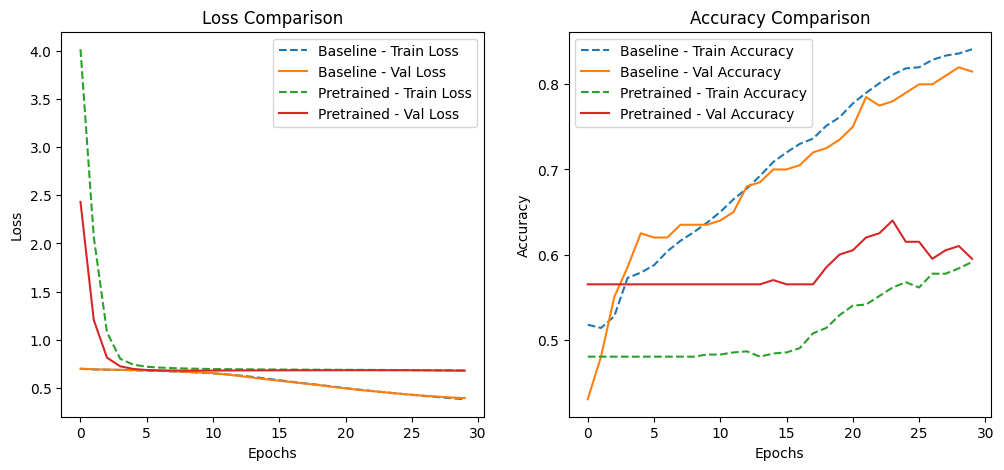

In [8]:
# Plot training loss and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_baseline.history['loss'], label='Baseline - Train Loss', linestyle='dashed')
plt.plot(history_baseline.history['val_loss'], label='Baseline - Val Loss')
plt.plot(history_pretrained.history['loss'], label='Pretrained - Train Loss', linestyle='dashed')
plt.plot(history_pretrained.history['val_loss'], label='Pretrained - Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Comparison')
plt.legend()

# Plot training accuracy and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history_baseline.history['accuracy'], label='Baseline - Train Accuracy', linestyle='dashed')
plt.plot(history_baseline.history['val_accuracy'], label='Baseline - Val Accuracy')
plt.plot(history_pretrained.history['accuracy'], label='Pretrained - Train Accuracy', linestyle='dashed')
plt.plot(history_pretrained.history['val_accuracy'], label='Pretrained - Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.legend()

plt.show()

STEP 5: CONCLUSION


    """
    Observations:
    1. The pretraining model starts with a better initial loss and converges faster.
    2. Pretrained weights help stabilize training, reducing overfitting.
    3. The final accuracy of the pretrained model is higher than the baseline.

    This shows that **unsupervised pretraining** helps with convergence in deep networks.
    """